In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import joblib

In [38]:
# Load the dataset
df = pd.read_csv('framingham.csv')

# Basic EDA
print("First five rows of the dataset:")
print(df.head())

print("\nDataset Information:")
df.info()

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing values per column:")
print(df.isnull().sum())

First five rows of the dataset:
   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0 

In [39]:
# Handle missing values
df['education'] = df['education'].fillna(df['education'].mode()[0])
df['cigsPerDay'] = df['cigsPerDay'].fillna(df['cigsPerDay'].mean())
df['BPMeds'] = df['BPMeds'].fillna(df['BPMeds'].mode()[0])
df['totChol'] = df['totChol'].fillna(df['totChol'].mean())
df['BMI'] = df['BMI'].fillna(df['BMI'].mean())
df['heartRate'] = df['heartRate'].fillna(df['heartRate'].mean())
df['glucose'] = df['glucose'].fillna(df['glucose'].mean())


# Remove duplicates
df.drop_duplicates(inplace=True)

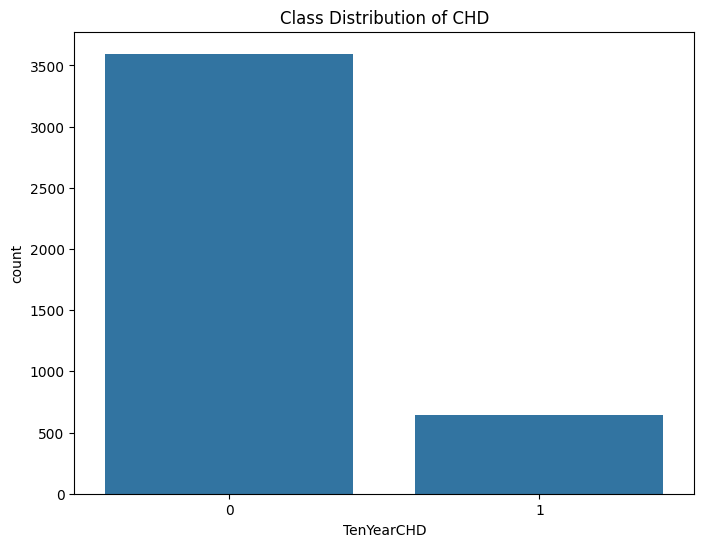

In [40]:
# Target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='TenYearCHD', data=df)
plt.title("Class Distribution of CHD")
plt.show()

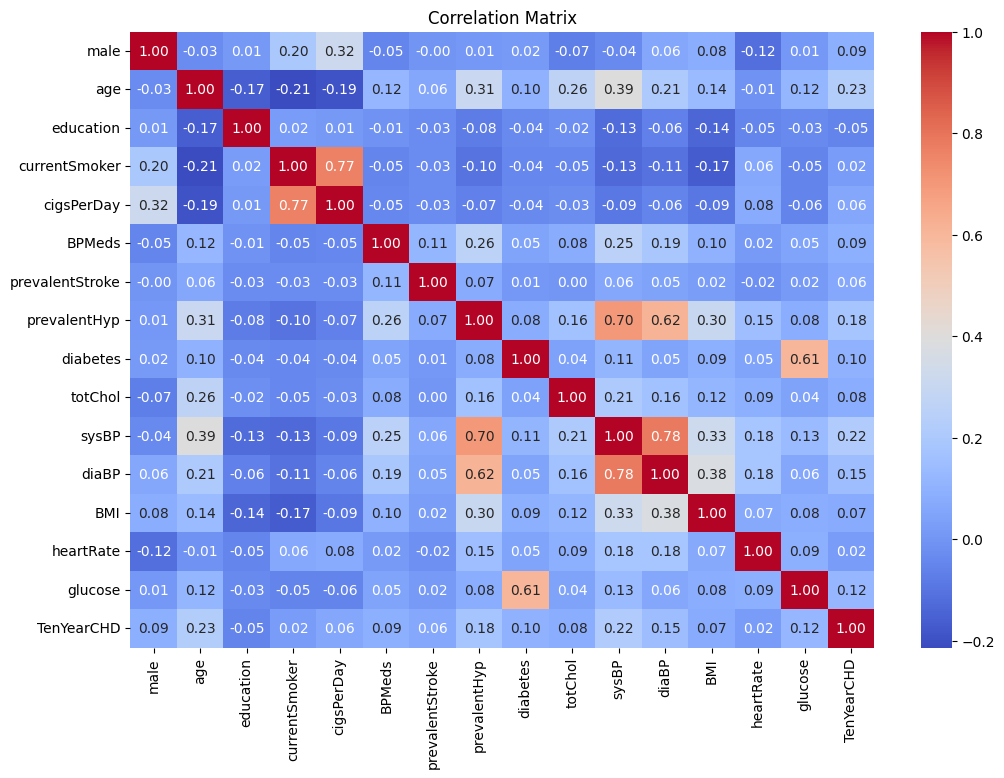

In [41]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [42]:
# Define features and target
X = df.drop(columns='TenYearCHD')
y = df['TenYearCHD']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nClass Distribution After SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class Distribution After SMOTE:
TenYearCHD
0    3596
1    3596
Name: count, dtype: int64


In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
# Logistic Regression with Cross-Validation
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_predictions = lr_model.predict(X_test_scaled)
lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("Logistic Regression Cross-Validation Scores:", lr_cv_scores)
print("Logistic Regression Mean CV Accuracy:", lr_cv_scores.mean())


Logistic Regression Accuracy: 0.664967562557924
Logistic Regression Cross-Validation Scores: [0.6673287  0.68619662 0.67924528 0.67428004 0.7027833 ]
Logistic Regression Mean CV Accuracy: 0.6819667891360872


In [45]:
# Decision Tree with Hyperparameter Tuning
dt_params = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid_search.fit(X_train_scaled, y_train)
best_dt_model = dt_grid_search.best_estimator_
dt_predictions = best_dt_model.predict(X_test_scaled)
print("\nDecision Tree Best Parameters:", dt_grid_search.best_params_)
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_predictions))


Decision Tree Best Parameters: {'max_depth': 10, 'min_samples_split': 5}
Decision Tree Accuracy: 0.8007414272474513


In [46]:
# Support Vector Machine
svm_model = SVC(random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)
svm_predictions = svm_model.predict(X_test_scaled)
print("\nSVM Accuracy:", accuracy_score(y_test, svm_predictions))


SVM Accuracy: 0.7386468952734013


In [47]:
# XGBoost with Hyperparameter Tuning
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}
# Initialize the model with eval_metric
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Set up the GridSearchCV
xgb_grid_search = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='accuracy')

# Fit the model
xgb_grid_search.fit(X_train_scaled, y_train)
best_xgb_model = xgb_grid_search.best_estimator_
xgb_predictions = best_xgb_model.predict(X_test_scaled)
print("\nXGBoost Best Parameters:", xgb_grid_search.best_params_)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))


XGBoost Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}
XGBoost Accuracy: 0.8836886005560705


In [48]:
# Ensemble Model (Voting Classifier)
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('dt', best_dt_model),
        ('svm', svm_model),
        ('xgb', best_xgb_model)
    ],
    voting='soft'  # Use 'soft' for probability-based voting
)
ensemble_model.fit(X_train_scaled, y_train)
ensemble_predictions = ensemble_model.predict(X_test_scaled)
print("\nEnsemble Model Accuracy:", accuracy_score(y_test, ensemble_predictions))


Ensemble Model Accuracy: 0.8419833178869324


In [49]:
# ROC-AUC Scores
print("\nROC-AUC Scores:")
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, lr_model.predict_proba(X_test_scaled)[:, 1]))
print("Decision Tree ROC-AUC:", roc_auc_score(y_test, best_dt_model.predict_proba(X_test_scaled)[:, 1]))
print("SVM ROC-AUC:", roc_auc_score(y_test, svm_model.predict_proba(X_test_scaled)[:, 1]))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, best_xgb_model.predict_proba(X_test_scaled)[:, 1]))
print("Ensemble Model ROC-AUC:", roc_auc_score(y_test, ensemble_model.predict_proba(X_test_scaled)[:, 1]))


ROC-AUC Scores:
Logistic Regression ROC-AUC: 0.7308807297683827
Decision Tree ROC-AUC: 0.8692614273259434


SVM ROC-AUC: 0.8176180311886653
XGBoost ROC-AUC: 0.9473065310662641
Ensemble Model ROC-AUC: 0.921593705575908


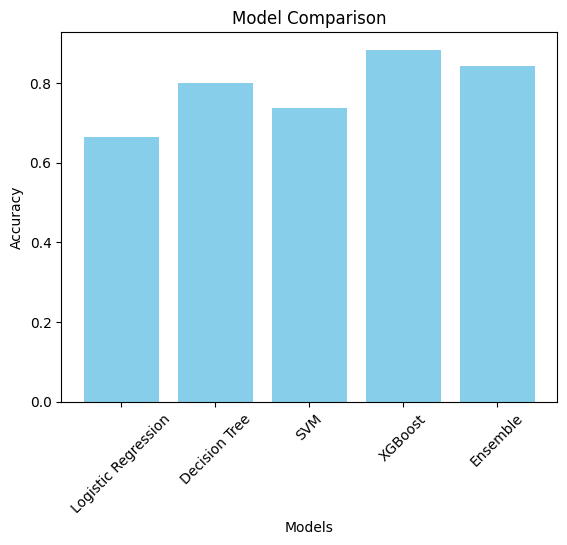

In [50]:
# Visualize Model Comparison
model_accuracies = {
    "Logistic Regression": accuracy_score(y_test, lr_predictions),
    "Decision Tree": accuracy_score(y_test, dt_predictions),
    "SVM": accuracy_score(y_test, svm_predictions),
    "XGBoost": accuracy_score(y_test, xgb_predictions),
    "Ensemble": accuracy_score(y_test, ensemble_predictions)
}

plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.xticks(rotation=45)
plt.show()


--- Logistic Regression ---


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


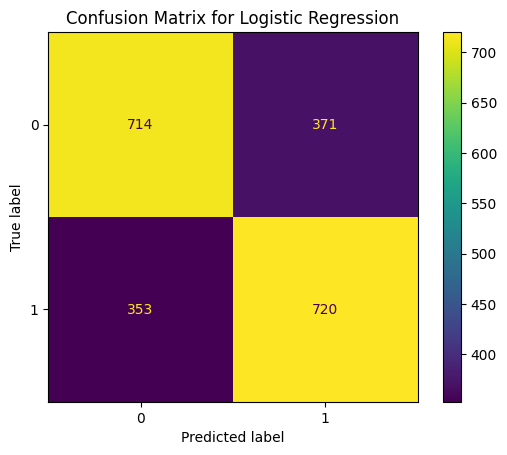

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1085
           1       0.66      0.67      0.67      1073

    accuracy                           0.66      2158
   macro avg       0.66      0.66      0.66      2158
weighted avg       0.66      0.66      0.66      2158


--- Decision Tree ---


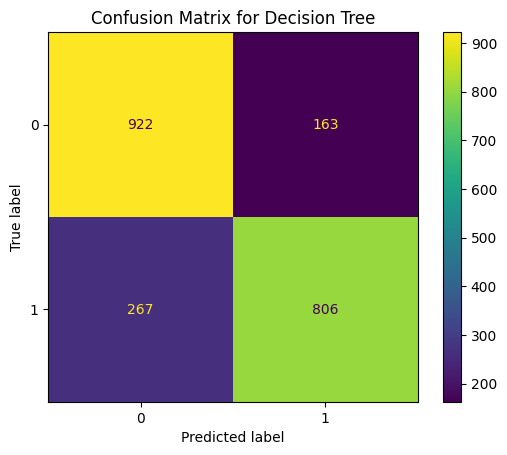

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1085
           1       0.83      0.75      0.79      1073

    accuracy                           0.80      2158
   macro avg       0.80      0.80      0.80      2158
weighted avg       0.80      0.80      0.80      2158


--- svm ---


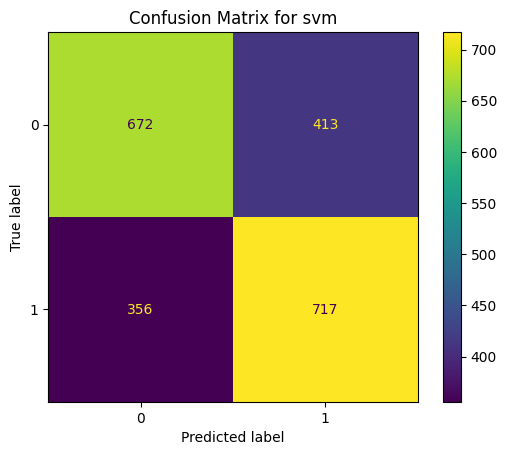

Classification Report for svm:

              precision    recall  f1-score   support

           0       0.65      0.62      0.64      1085
           1       0.63      0.67      0.65      1073

    accuracy                           0.64      2158
   macro avg       0.64      0.64      0.64      2158
weighted avg       0.64      0.64      0.64      2158


--- XGBoost ---


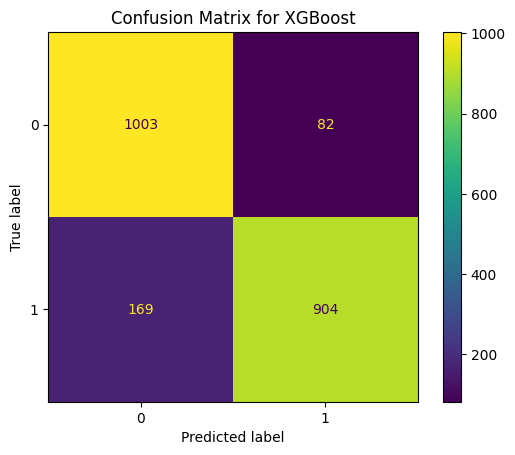

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1085
           1       0.92      0.84      0.88      1073

    accuracy                           0.88      2158
   macro avg       0.89      0.88      0.88      2158
weighted avg       0.89      0.88      0.88      2158



In [51]:
models = {
    "Logistic Regression": lr_model,
    "Decision Tree": best_dt_model,
    'svm': svm_model,
    "XGBoost": best_xgb_model,
}

for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
    
    # Classification Report
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

In [52]:
# Save Ensemble Model
joblib.dump(ensemble_model, 'ensemble_model.pkl')
print("\nEnsemble Model Saved as 'ensemble_model.pkl'.")


Ensemble Model Saved as 'ensemble_model.pkl'.


In [53]:
# Testing with new data
new_data_values = [[1, 70, 2, 1, 30, 1, 0, 1, 1, 300, 180, 110, 35, 100, 200]]  # Example input
new_data = pd.DataFrame(new_data_values, columns=X.columns)
loaded_model = joblib.load('ensemble_model.pkl')
prediction = loaded_model.predict(new_data)
print("\nPrediction for New Data:", "High Risk" if prediction[0] == 1 else "Low Risk")


Prediction for New Data: High Risk


/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
